
```
---
title: Insult Classifcation
type:  lesson + lab + demo
duration: "1:25"
creator:
    name: David Yerrington
    city: SF
---
```
<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; width: 50px; margin: 10px">

#  Naive Bayes Demo / Lab + NLP
Week 8 | 4.3

![](https://snag.gy/i5b9BX.jpg)

In this dataset, we will be looking at labeled comments that look something like this:

> <div style="float: left; margin-right: 20px;"><img src="https://snag.gy/xX9hMZ.jpg" style="float: left; margin-right: 10px; width: 60px;">**Moon Master99BBQ**<br>Insult Connoisseur</div>"You're all upset, defending this hipster band...and WE'RE the douches for reading the news and discussing it?  Put down the PBR, throw away the trucker hat, shave off that silly shadow-beard, put down your "99%er" sign, and get a job, ION."

Fair warning, the content is fairly provacative but this type of problem is very common in the continuum of comment threads throughout the web.  You can also use this type of pipeline to build custom sentiment features for content specific domains that can be much more effecive than say TextBlob, for relatively low effort.


In [2]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [3]:
insults_df = pd.read_csv("assets/datasets/train.csv", encoding="utf-8")
# insults_df = pd.read_csv("/Users/davidyerrington/Downloads/train.csv")
# insults_df_test = pd.read_csv("assets/datasets/test.csv", encoding="utf-8")

In [4]:
insults_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 3 columns):
Insult     3947 non-null int64
Date       3229 non-null object
Comment    3947 non-null object
dtypes: int64(1), object(2)
memory usage: 92.6+ KB


*There are a variety of colorful expletives observed throughout this dataset.  This activity is strictly educational though and you should excersize critical thinking dispite the potentail comedic nature of the content.*

In [5]:
insults_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 3 columns):
Insult     3947 non-null int64
Date       3229 non-null object
Comment    3947 non-null object
dtypes: int64(1), object(2)
memory usage: 92.6+ KB


In [6]:
insults_df.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [7]:

mask = insults_df['Comment'].map(lambda text: len(text) == 6)
insults_df[mask]

,Insult,Date,Comment
2937,0,20120610052534Z,"""Fuck"""
3112,0,20120618221322Z,"""Shit"""


### 1. Explore a list of comment words that occur more than 50x
Plot a histogram of some kind might be helpful.

In [8]:
############
# DO NOT USE THIS CODE FOR COUNTING TOKENS!!!!
################

# import pandas as pd

# cvt = CountVectorizer(strip_accents='unicode', stop_words="english", ngram_range=(2,4))
# X_all = cvt.fit_transform(insults_df['Comment'])
# # X_all.toarray()
# # cvt.get_feature_names()

# sorted( 
#     zip(
#         cvt.get_feature_names(), # <--- the previous verions uses cvt.vocabulary_.keys() which is a dictionary 
#         pd.DataFrame(
#             X_all.todense(), 
#             columns=cvt.get_feature_names()).sum()
#     ), 
#     key      =  lambda item: item[1],
#     reverse  =  True
# )


######
#  Use this code instead for exploring counts
#########
cvt      =  CountVectorizer(strip_accents='unicode', ngram_range=(2,4))
X_all    =  cvt.fit_transform(insults_df['Comment'])
columns  =  cvt.get_feature_names()

x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(10)


,freq
you are,595
xc2 xa0,379
in the,377
of the,350
you re,249
to be,223
xe2 x80,209
to the,196
if you,177
on the,176


## Investigate Histogram of Counts

/Users/davidyerrington/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


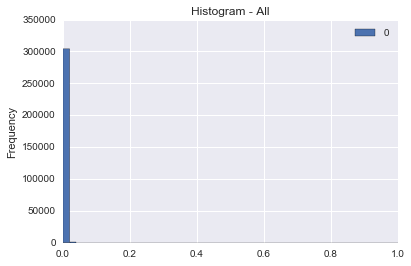

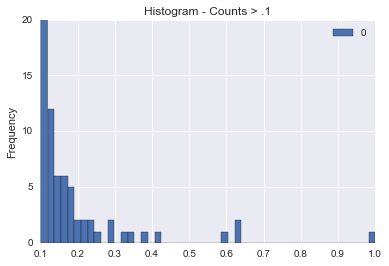

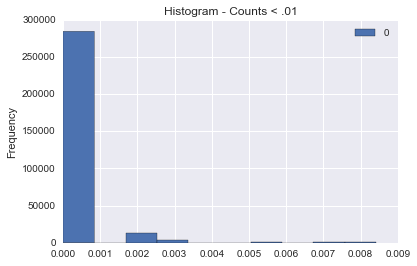

In [9]:
from sklearn.preprocessing import StandardScaler, minmax_scale

def hist_counts(X_all):

    count_df = pd.DataFrame(X_all.toarray())
    hist_counts = pd.DataFrame(minmax_scale(count_df.sum()))
    hist_counts.plot(kind="hist", bins=50, title="Histogram - All")
    hist_counts[hist_counts[0] > .1].plot(kind="hist", bins=50, title="Histogram - Counts > .1") # There are a lot of really common tokens within 10% -- filter them out
    hist_counts[hist_counts[0] < .01].plot(kind="hist", title="Histogram - Counts < .01") # look at the range of extreme commons that seem to exist below .01
    
hist_counts(X_all)

### 1.5 Try it again with stopword removal 

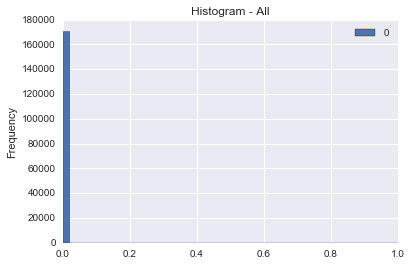

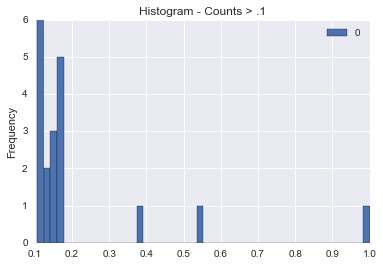

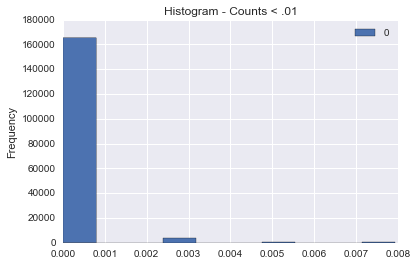

In [28]:
cvt      =  CountVectorizer(strip_accents='unicode', stop_words="english", ngram_range=(2,4))
X_all    =  cvt.fit_transform(insults_df['Comment'])
# columns  =  cvt.get_feature_names()
hist_counts(X_all)

In [12]:
## Let's see what's hanging out in the extremely common and uncommon ranges
x_df     =  pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])

# tf_df.sort_values("freq", ascending=False).head(10)

In [57]:
# Checking range between .99 - .99999
tf_df.freq.quantile(.99999)

163.18540000056964

In [62]:
# find the %1, and %10 threashold for masking
tf_df[(tf_df['freq'] >= 10) & (tf_df['freq'] <= 150)].sort_values("freq", ascending=False)


,freq
xa0 xa0,144
shar es,68
http shar es,68
http shar,68
trade trade,63
trade trade trade,62
trade trade trade trade,61
u2026 u2026,59
xa0 xa0 xa0,57
u2026 u2026 u2026,52


### 2. Explore ngrams between 2 and 4
Display the top 75 ngrams with frequencies.

In [67]:
cvt = CountVectorizer(stop_words="english", ngram_range=(4,6))
X_all = cvt.fit_transform(insults_df['Comment'])
x_df     =  pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(10)

,freq
trade trade trade trade,61
trade trade trade trade trade,60
trade trade trade trade trade trade,59
xa0 xa0 xa0 xa0,49
u2026 u2026 u2026 u2026,45
xa0 xa0 xa0 xa0 xa0,45
xa0 xa0 xa0 xa0 xa0 xa0,42
u2026 u2026 u2026 u2026 u2026,39
xc2 xa0 xc2 xa0,35
u2026 u2026 u2026 u2026 u2026 u2026,33


### 3. (Optional) try expanding the list of stopwords
There's definitely some extra crap floating around our lovely ngrams like xa0, x80, web urls, and a bunch of other things.  If you could remove them, this could help us improve the score.  Identify words / tokens that don't add much value to either class.  **You should additionally look at ngrams per class (insults vs non-insults) to fine tune your preprocessing.  This has the greatest potential to improve your results without tuning any model parameters.**

Using `nltk.corpus`, we can get a baseline list of stop words.  Try to expand it and pass it to our vectorizer.

In [89]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['xa0', 'x80', 'xc2', 'xe3']
stop.append("need")
stop.append("in")
stop.append("re")
stop.append("are")
stop.append("for")
stop.append("have")
stop.append("like")
stop.append("be")
stop.append("see")
stop.append("do")
stop.append("trade")
stop.append("u2026")
stop.append("http")
stop.append("mrzlgv")
stop.append("bit")
stop.append("ly")
stop.append("div")
stop.append("class")
stop.append("forum")
stop.append("item")
stop.append("shar")
stop.append("profile")
stop.append("es")

stop += ['people', 'go', 'know', 'think', 'get', 'us', 'really', 'way', 'xe2', 'got', 'want', 'well']

In [91]:
# These look pretty clean for a first step in anlaysis
cvt = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
X_all = cvt.fit_transform(insults_df['Comment'])
x_df     =  pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(20)

,freq
would,371
one,360
fuck,242
right,223
time,219
make,211
good,207
back,189
even,185
say,183


### 4. Setup a test / train split of your data using any method you wish.
Try 70/30 to start.

In [108]:
# Find our training size
training_size = int(insults_df.shape[0] * .7)

# Randomly sample our training data
insults_train = insults_df.sample(n=training_size, replace=True)

# Capture the rest of the dataset that's not "training" using an inverse mask (rows NOT IN training dataframe)
mask = insults_df.index.isin(insults_train.index)
insults_test = insults_df[~mask]

# Should be (2762, 1963) = training / testing = 70/30
insults_train.shape[0], insults_test.shape[0]

(2762, 1952)

### 5. Setup a "Pipeline" to vectorize and use MultinomialNB classifier.
Check out our last lab to set this up.  Use lowercase, strip_accents, and optionally your updated stop_words.  Fit your comment data using your "Insult" feature as your response.

Fit your training data to your pipeline.  

In [124]:
# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop)),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(insults_train["Comment"], insults_train["Insult"])
predicted = pipeline.predict(insults_test["Comment"])
pipeline.score(insults_test["Comment"], insults_test["Insult"])

0.74897540983606559

In [167]:
# Alternative -- train on all data for later data mining of reddit comments
# MultinomialNB
pipeline = Pipeline([
    ('vect', cvt),
    # ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(insults_df["Comment"], insults_df["Insult"])
predicted = pipeline.predict(insults_df["Comment"])
pipeline.score(insults_df["Comment"], insults_df["Insult"])

0.98707879402077525

In [102]:
#  Add predicted probabilities back to original dataframe
insults_df['Predicted'] = predicted

### 5.5a Swap out MultinomialNB with BernoulliNB in the pipeline
How do they compare?

### 5.5a Also try logistic regression, and random forrests in the pipeline
How do they compare?

#### 5.5b Also try tweeking the paramters of CountVectorizer and TfidfTranformer.

Remove Tfidf also. Good / bad?

### 6. Check your score.
Also, run a classification report and [plot AUC/ROC](../../week-04/2.3-evaluating_model_fit/code/AUC-ROC-codealong.ipynb).  Also, [review classfication reporting metrics](../../week-04/4.3-advanced-model_evaluation/code/starter-code/week4-4.1-classification-report.ipynb).

In [107]:
insults_test.shape, len(predicted)

((1951, 4), 3947)

In [110]:
print classification_report(insults_test["Insult"], predicted, target_names=["Insult", "Neutral"])

             precision    recall  f1-score   support

     Insult       0.75      1.00      0.85      1423
    Neutral       0.90      0.08      0.15       529

avg / total       0.79      0.75      0.66      1952



### Revisiting:  Learning Curves

![](https://snag.gy/GoUvNw.jpg)

We touched on this briefly in the past but lets reprise the idea of sample size effect on validation score.  How do we know the optimal sample size to train and test on?  We can examine the scores of training and cross validation given a number of samples.  Plotting the scores is a great way to understand:

- How to improve bias / generalization (out of sample prediction)
- Generally how many samples you might need
- The bounds of your models performance 

Generally, the learning curves represent the number of samples that have been used, the average scores on the training sets and the average scores on the validation sets.  

See also [validation curves](http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#example-model-selection-plot-validation-curve-py) for model parameter *(aka: hyper parameter)* tuning, also [calibration plots](http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html).

In [19]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [20]:
crap = insults_df.sample(n=20000, replace=True)

<module 'matplotlib.pyplot' from '/Users/davidyerrington/anaconda/envs/dsi/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

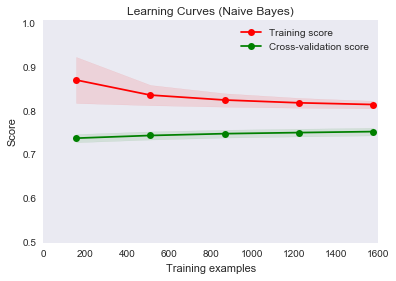

In [21]:
# Pipeline variable can be replaced by your already established estimator
cv = ShuffleSplit(insults_df.shape[0], n_iter=100, test_size=0.6, random_state=0)
plot_learning_curve(pipeline, "Learning Curves (Naive Bayes)", insults_df['Comment'], insults_df['Insult'], ylim=(0.5, 1.01), cv=cv, n_jobs=4)

# plot_learning_curve(pipeline, "bla", )

In [112]:
def multi_roc(y, probs):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        # probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [117]:
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 21), rotation=45)
    plt.yticks(np.linspace(0, 1, 21))
    plt.show()

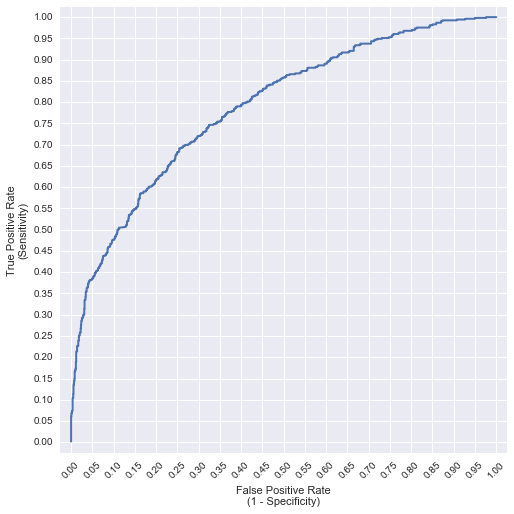

In [128]:
predicted = pipeline.predict_proba(insults_test['Comment'])
plot_roc(insults_test['Insult'], predicted[:, 1])

### 6.5 Check out your baseline.

What is the chance that you will randomly guess correctly without any modeling? Insult vs neutral.

In [119]:
insults_train.Insult.sum() * 1.0 / insults_train.Insult.count() * 1.0

0.25742215785662564

### 7. Check the accuracy of your model with the holdout dataset "test_with_solutions.csv"

Using the `test_with_solutions.csv`, we will test our model on another set of data it has never seen before.  Also plot the same eval metrics (classification report, AUC/ROC).

In [129]:
test_df = pd.read_csv("assets/datasets/test_with_solutions.csv", encoding="utf-8")
test_df.head()
pipeline.score(test_df['Comment'], test_df['Insult'])

0.76955043445409899

### 8. What is your model not getting right?

Check out false positives and true negatives.  Any noticable patterns?  Pay particular attention to the recall metric.  What might be done in preprocessing steps to improve accuracy?  

- Try to improve with your **preprocessing first**
- THEN try to tweek your **parameters to your model(s)**

In [121]:
print classification_report(insults_test["Insult"], predicted, target_names=["Neutral", "Insult"])

ValueError: Mix type of y not allowed, got types set(['binary', 'continuous-multioutput'])

## Lastly...

Check [this blog post](http://webmining.olariu.org/my-first-kaggle-competition-and-how-i-ranked/) by a guy who used SVM, a "neural network", a ton of cleaning, then placed 3rd in a Kaggle competition featuing this same dataset.  Given that you used a few basic techniques with preprocessing text and Naive Bayes, what do think about the tradeoffs of simplicity vs complexity of your model?

In [172]:
# insults_test.loc[:'prob'] = predicted
# insults_df.loc[:"prob"] = predicted
# insults_df
insults_df['predicted'] = predicted
# predicted.shape, insults_df.shape

In [191]:
insults_df['proba'] = np.round(pipeline.predict_proba(insults_df["Comment"])[:, 1:], 3)

In [192]:
insults_df[['predicted', 'proba']].values

array([[ 1.   ,  0.735],
       [ 0.   ,  0.007],
       [ 0.   ,  0.   ],
       ..., 
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ]])

In [195]:
# Anything above .7 is pretty foul
insults_df[['Comment', 'proba']][insults_df['proba'] > .7]

,Comment,proba
0,"""You fuck your dad.""",0.735
7,"""shut the fuck up. you and the rest of your fa...",1.000
8,"""Either you are fake or extremely stupid...may...",0.991
9,"""That you are an idiot who understands neither...",0.999
15,"""FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ...",0.999
16,"""You with the 'racist' screen name\n\nYou are ...",1.000
18,"""your such a dickhead...""",0.795
19,"""Your a retard go post your head up your #%&*""",0.958
34,"""Allinit123, your\xa0hypocrisy\xa0is sickening...",1.000
37,"""I can't believe the stupid people on this sit...",1.000


##  Connect to big query and collect more data to find insults for another project...

In [196]:
def get_all_comments():
    # "politics", "NoMansSkyTheGame", "The_Donald", "leagueoflegends", "news", "funny", "pics", 
    subreddits = ["videos", "olympics", "MMA"]
    all_df = False
    
    for subreddit in subreddits:
        
        sql = """
        SELECT bq.*, RAND() as random FROM [fh-bigquery:reddit_comments.2016_08] bq
        -- WHERE subreddit IN ("politics", "United States", "Great Britain")
        -- "NoMansSkyTheGame", "The_Donald", "leagueoflegends", "news", "funny", "pics"
        WHERE subreddit IN ("%s")
        ORDER BY random
        LIMIT 500000
        """ % subreddit

        print "Fetching comments for subreddit: %s" % subreddit
        df = gbq.read_gbq(sql, project_id="redditcommentdata")
        
        try:
            print "Saving %s.csv....." % subreddit
            df.to_csv("%s.csv" % subreddit, encoding="utf8", index=False)
        except:
            print "Skipping %s, df type:  %s " % (subreddit, type(df))

    print "COMPLETET!!!!!!!!"

In [199]:
from pandas.io import gbq
# df = gbq.read_gbq('SELECT * FROM MyDataset.MyTable', project_id='my-project-id')

sql = """
SELECT * FROM [fh-bigquery:reddit_posts.full_corpus_201509] WHERE ups > 10 LIMIT 10
"""

sql = """
SELECT bq.*, RAND() as random FROM [fh-bigquery:reddit_comments.2016_08] bq
-- WHERE subreddit IN ("politics", "United States", "Great Britain")
-- "NoMansSkyTheGame", "The_Donald", "leagueoflegends", "news", "funny", "pics"
WHERE subreddit IN ("politics")
ORDER BY random
LIMIT 500000
"""

df = gbq.read_gbq(sql, project_id="redditcommentdata", reauth=True)


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/v2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&response_type=code&client_id=495642085510-k0tmvj2m941jhre2nbqka17vqpjfddtd.apps.googleusercontent.com&access_type=offline

If your browser is on a different machine then exit and re-run this
application with the command-line parameter

  --noauth_local_webserver

Authentication successful.
Requesting query... ok.
Query running...
  Elapsed 11.25 s. Waiting...
  Elapsed 21.43 s. Waiting...
Query done.
Processed: 19.9 Gb

Retrieving results...
  Got page: 1; 3.0% done. Elapsed 33.36 s.
  Got page: 2; 7.0% done. Elapsed 39.81 s.
  Got page: 3; 10.0% done. Elapsed 45.96 s.
  Got page: 4; 13.0% done. Elapsed 51.85 s.
  Got page: 5; 17.0% done. Elapsed 57.78 s.
  Got page: 6; 20.0% done. Elapsed 64.51 s.
  Got page: 7; 23.0% done. Elapsed 70.41 s.
  Got page: 8; 27.0% done. Elapsed 76.92 s.
  Got page:

In [201]:
predicted_reddit_insults = pipeline.predict_proba(df['body'])

In [202]:
df['proba'] = np.round(predicted_reddit_insults[:, 1:], 3)

In [206]:
# df[df.proba > .5]['body']

In [10]:
df = get_all_comments()

Fetching comments for subreddit: videos
Requesting query... ok.
Query running...


GenericGBQException: Reason: quotaExceeded, Message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/troubleshooting-errors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500012 entries, 0 to 500011
Data columns (total 21 columns):
body                      499989 non-null object
score_hidden              0 non-null float64
archived                  0 non-null float64
name                      0 non-null float64
author                    500000 non-null object
author_flair_text         3070 non-null object
downs                     0 non-null float64
created_utc               500000 non-null float64
subreddit_id              500000 non-null object
link_id                   500000 non-null object
parent_id                 500000 non-null object
score                     500000 non-null float64
retrieved_on              500000 non-null float64
controversiality          500000 non-null float64
gilded                    500000 non-null float64
id                        500000 non-null object
subreddit                 500000 non-null object
ups                       500000 non-null float64
distinguished      

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
body                      500000 non-null object
score_hidden              0 non-null object
archived                  0 non-null object
name                      0 non-null object
author                    500000 non-null object
author_flair_text         96 non-null object
downs                     0 non-null float64
created_utc               500000 non-null int64
subreddit_id              500000 non-null object
link_id                   500000 non-null object
parent_id                 500000 non-null object
score                     500000 non-null int64
retrieved_on              500000 non-null int64
controversiality          500000 non-null int64
gilded                    500000 non-null int64
id                        500000 non-null object
subreddit                 500000 non-null object
ups                       500000 non-null int64
distinguished             4528 non-n

### Comments by SubReddit

In [14]:
sql = """
SELECT subreddit, COUNT(*) AS comment_count FROM [fh-bigquery:reddit_comments.2016_08] 
GROUP BY subreddit
ORDER BY comment_count DESC
"""

gbq.read_gbq(sql, project_id="redditcommentdata")

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63080 rows.

Total time taken 3.4 s.
Finished at 2016-10-06 16:03:54.


,subreddit,comment_count
0,AskReddit,5116323
1,politics,1465028
2,NoMansSkyTheGame,789567
3,pokemongo,757049
4,Overwatch,741399
5,The_Donald,717105
6,leagueoflegends,706350
7,worldnews,677032
8,SquaredCircle,654389
9,news,582458


In [17]:
sql = """
SELECT author_flair_text, COUNT(*) AS comment_count FROM [fh-bigquery:reddit_comments.2016_08] 
GROUP BY author_flair_text
ORDER BY comment_count ASC
"""

gbq.read_gbq(sql, project_id="redditcommentdata")

Requesting query... ok.
Query running...
Query done.
Processed: 363.9 Mb

Retrieving results...
  Got page: 1; 16.0% done. Elapsed 13.76 s.
  Got page: 2; 32.0% done. Elapsed 18.74 s.
  Got page: 3; 48.0% done. Elapsed 24.15 s.
  Got page: 4; 64.0% done. Elapsed 29.72 s.
  Got page: 5; 80.0% done. Elapsed 34.64 s.
  Got page: 6; 97.0% done. Elapsed 40.51 s.
  Got page: 7; 100.0% done. Elapsed 41.89 s.
Got 621228 rows.

Total time taken 46.16 s.
Finished at 2016-10-06 16:52:50.


,author_flair_text,comment_count
0,That One Cat,119
1,Ninja 300/ KTM MXC250,119
2,HENkaku,119
3,2 huskies 1 weim,119
4,Linux Mint 18 Sarah | Cinnamon,119
5,Shower Mod,119
6,Danny Leroux (NBA ANALYST)- Verified,119
7,AMD A8 6600K/ GTX 760/ 8GB RAM/Windows 10,119
8,L1 Allô ween ? Ici trouille !,119
9,SGP,119


In [96]:
# columns = ['title', 'subreddit_id', 'author', 'over_18', 'quarantine', 'author_flair_text', 'distinguished', 'ups']

# df[columns]['title'].values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
body                      500000 non-null object
score_hidden              0 non-null object
archived                  0 non-null object
name                      0 non-null object
author                    500000 non-null object
author_flair_text         104 non-null object
downs                     0 non-null float64
created_utc               500000 non-null int64
subreddit_id              500000 non-null object
link_id                   500000 non-null object
parent_id                 500000 non-null object
score                     500000 non-null int64
retrieved_on              500000 non-null int64
controversiality          500000 non-null int64
gilded                    500000 non-null int64
id                        500000 non-null object
subreddit                 500000 non-null object
ups                       500000 non-null int64
distinguished             4561 non-

In [26]:
import folium

%matplotlib inline


In [68]:
import json

with open("countries.geo.json") as fp:

    geo = json.load(fp)
    print geo['features'][1]

{u'geometry': {u'type': u'MultiPolygon', u'coordinates': [[[[16.326528, -5.87747], [16.57318, -6.622645], [16.860191, -7.222298], [17.089996, -7.545689], [17.47297, -8.068551], [18.134222, -7.987678], [18.464176, -7.847014], [19.016752, -7.988246], [19.166613, -7.738184], [19.417502, -7.155429], [20.037723, -7.116361], [20.091622, -6.94309], [20.601823, -6.939318], [20.514748, -7.299606], [21.728111, -7.290872], [21.746456, -7.920085], [21.949131, -8.305901], [21.801801, -8.908707], [21.875182, -9.523708], [22.208753, -9.894796], [22.155268, -11.084801], [22.402798, -10.993075], [22.837345, -11.017622], [23.456791, -10.867863], [23.912215, -10.926826], [24.017894, -11.237298], [23.904154, -11.722282], [24.079905, -12.191297], [23.930922, -12.565848], [24.016137, -12.911046], [21.933886, -12.898437], [21.887843, -16.08031], [22.562478, -16.898451], [23.215048, -17.523116], [21.377176, -17.930636], [18.956187, -17.789095], [18.263309, -17.309951], [14.209707, -17.353101], [14.058501, -17

In [33]:
%%bash

cat countries.geo.json

{"type":"FeatureCollection","features":[
{"type":"Feature","id":"AFG","properties":{"name":"Afghanistan"},"geometry":{"type":"Polygon","coordinates":[[[61.210817,35.650072],[62.230651,35.270664],[62.984662,35.404041],[63.193538,35.857166],[63.982896,36.007957],[64.546479,36.312073],[64.746105,37.111818],[65.588948,37.305217],[65.745631,37.661164],[66.217385,37.39379],[66.518607,37.362784],[67.075782,37.356144],[67.83,37.144994],[68.135562,37.023115],[68.859446,37.344336],[69.196273,37.151144],[69.518785,37.608997],[70.116578,37.588223],[70.270574,37.735165],[70.376304,38.138396],[70.806821,38.486282],[71.348131,38.258905],[71.239404,37.953265],[71.541918,37.905774],[71.448693,37.065645],[71.844638,36.738171],[72.193041,36.948288],[72.63689,37.047558],[73.260056,37.495257],[73.948696,37.421566],[74.980002,37.41999],[75.158028,37.133031],[74.575893,37.020841],[74.067552,36.836176],[72.920025,36.720007],[71.846292,36.509942],[71.262348,36.074388],[71.498768,35.650563],[71.613076,35.153203

In [89]:
data = {"test1": 123, "test2": 53434, "test3": {}, "test4": {}}
# find keys with {} values 
data.update({
    "test3": "updated", 
    "test4": "updated"
})
data

{'test1': 123, 'test2': 53434, 'test3': 'updated', 'test4': 'updated'}

In [84]:
data = [
    {"id": "AGO", "count": 100},
    {"id": "AFG", "count": 50},
]


# Create dataframe
df = pd.DataFrame(data)

#Let Folium determine the scale
testmap = folium.Map(location=[48, -102], zoom_start=3)
testmap.geo_json(geo_path="countries.geo.json", data=df,
             columns=['id', 'count'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment Rate (%)')

testmap
# df

KeyError: u'ALB'

In [18]:
# # MultinomialNB
# pipeline = Pipeline([
#     ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
#     ('cls', MultinomialNB())
# ]) 
# pipeline.fit(insults_train["Comment"], insults_train["Insult"])
# pipeline.score(insults_test["Comment"], insults_test["Insult"])

df = pd.read_csv("./NoMansSkyTheGame.csv", encoding="utf8")

predicted = pipeline.predict_proba(df["body"])


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
df['insult_proba'] = predicted[:, 1]
df

In [118]:
df[['subreddit','body', 'author', 'score', 'insult_proba']][df['insult_proba'] > .7]['body'].tail(50).values

array([ u"He also has a black adopted son, so it's hard to really call him racist, but he says some horribly racist things.",
       u"To be fair, Trump has no attention span, has never read a book in his entire life, and is cartoonishly ignorant about global and domestic affairs, and their accompanying history. \n\nTrump's knowledge, understanding, and grasp on history probably doesn't go back beyond what's happened in the last few days. \n",
       u'Such a tired, stupid act for a base of tired, stupid voters.  I can do the whole act myself at this point:\n\n"Ah, but where\'s the evidence I don\'t know about yet?"\n\n"There is none."\n\n"But I just said there was.  Where is it?"\n\n"Well, there isn\'t any.  This is it.  Literally."\n\n"COVERUP!!!!"\n\n\nIt takes a special kind of stupid to buy that line of argument, and a special kind of asshole to assume his voters are that dim.',
       u"So let me get this straight....\n\nIf making it hard for poor people to vote causes 30,000 whi